In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [84]:
df= pd.read_csv("/content/DELL.csv")
df1=df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,21.777945,22.993132,21.693752,22.440264,21.538488,13801490
1,2017-12-04,22.504812,22.521650,20.952852,21.017401,20.172800,8513645
2,2017-12-05,20.927595,21.278399,20.644144,20.899530,20.059671,6129126
3,2017-12-06,20.767628,21.182980,20.697468,21.065109,20.218594,7828790
4,2017-12-07,21.278399,21.601139,21.205433,21.298044,20.442167,7163534
...,...,...,...,...,...,...,...
1386,2023-06-07,46.860001,47.779999,46.770000,47.660000,47.660000,4096000
1387,2023-06-08,47.990002,48.099998,47.200001,47.889999,47.889999,3976100
1388,2023-06-09,48.090000,48.669998,47.590000,47.610001,47.610001,3293500
1389,2023-06-12,47.720001,48.119999,47.619999,48.070000,48.070000,3596800


In [85]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [86]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [87]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [88]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [89]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [90]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [91]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 4s 102ms/step - loss: 0.0262 - val_loss: 0.0111
Epoch 2/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0069 - val_loss: 0.0361
Epoch 3/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0032 - val_loss: 0.0362
Epoch 4/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0020 - val_loss: 0.0118
Epoch 5/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0014 - val_loss: 0.0128
Epoch 6/100
12/12 [==============================] - 1s 62ms/step - loss: 9.7931e-04 - val_loss: 0.0054
Epoch 7/100
12/12 [==============================] - 1s 61ms/step - loss: 6.5502e-04 - val_loss: 0.0029
Epoch 8/100
12/12 [==============================] - 1s 61ms/step - loss: 4.8295e-04 - val_loss: 0.0015
Epoch 9/100
12/12 [==============================] - 1s 61ms/step - loss: 4.1619e-04 - val_loss: 0.0011
Epoch 10/100
12/12 [==============================] - 1s 62ms/step - loss: 3.8850e-

In [92]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 11ms/step


In [93]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [94]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_mae = np.mean(np.abs((y_pred_val - yval)))
test_mae = np.mean(np.abs((y_pred - ytest)))
valid_mape = np.mean(np.abs((y_pred_val - yval)/yval))
test_mape = np.mean(np.abs((y_pred - ytest)/ytest))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 44.696462371284255
Testing RMSE: 48.60271006198308
Validation MAE: 44.66141630103133
Testing MAE: 48.070509077192426
Validation MAPE: 67.01714873715407
Testing MAPE: 68.19268606068164


In [98]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
n_stepss=80
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_stepss, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.73754525]
81
[0.73754525]
82
[0.73754525]
83
[0.73754525]
84
[0.73754525]
85
[0.73754525]
86
[0.73754525]
87
[0.73754525]
88
[0.73754525]
89
[0.73754525]
90
[0.73754525]
91
[0.73754525]
92
[0.73754525]
93
[0.73754525]
94
[0.73754525]
95
[0.73754525]
96
[0.73754525]
97
[0.73754525]
98
[0.73754525]
99
[0.73754525]
100
[0.73754525]
101
21 day input [0.59078804 0.58905413 0.59382245 0.58471926 0.57149788 0.56369508
 0.55936021 0.55350811 0.54527192 0.52966636 0.50647479 0.52316405
 0.5021399  0.47873163 0.47548046 0.49672131 0.49585431 0.50755849
 0.48956881 0.51839567 0.53140035 0.50820879 0.50257341 0.49303671
 0.50625809 0.51319387 0.53075006 0.54678913 0.55437511 0.57084767
 0.56868019 0.56716298 0.55480862 0.58081785 0.58450245 0.59035455
 0.60726062 0.6209154  0.63500376 0.6690325  0.63283636 0.61311261
 0.6172308  0.6079108  0.58688665 0.58601966 0.61051171 0.62546708
 0.63261958 0.65299343 0.66166322 0.64042235 0.6666483  0.68030317
 0.6794362  0.67618509 0.65169304 0.65299343 0

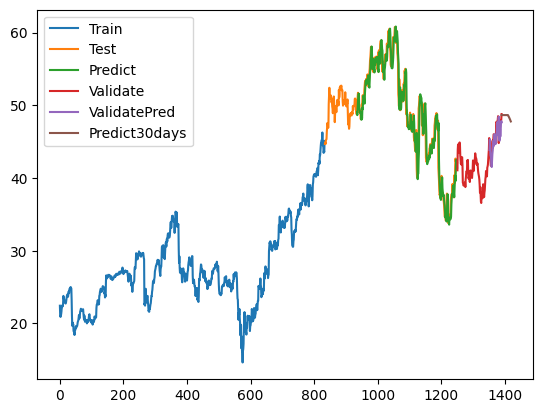

In [99]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()